# Importing relevant libraries

In [25]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

# Setting up the data folder

In [26]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/abans data set/")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/abans data set'

# Reading the data file

In [27]:
df = pd.read_csv("/content/drive/My Drive/abans data set/ABAN HISTORICAL DATA.csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/27/2023,151.0,151.00,151.00,150.0,0.14K,0.67%
1,12/22/2023,150.0,150.00,150.00,150.0,0.09K,-0.99%
2,12/21/2023,151.5,151.75,151.75,151.5,0.00K,1.00%
3,12/20/2023,150.0,147.00,151.75,147.0,0.08K,2.04%
4,12/19/2023,147.0,152.50,152.50,147.0,0.29K,0.00%


# Preprocessing the data

In [28]:
#Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Removing non-numeric characters and convert numerical columns to float
for col in df.columns[1:]:
    df[col] = df[col] .replace(r'[^\d.]', '', regex=True).astype(float)


# Drop rows with missing values
df.dropna(inplace=True)

#Normalizing the numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns='Date'))

# Creating time series data with three-day windows
lookback = 3
generator = TimeseriesGenerator(scaled_data, scaled_data, length=lookback, batch_size=1)



## Splitting the data into training and testing, maintaining an 80-20% split ratio.


In [29]:

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [30]:
#for LSTM model
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

#for training and testing data
X_train, y_train = create_sequences(train, lookback)
X_test, y_test = create_sequences(test, lookback)

#Reshaping the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#LSTM – RNN model Creation

In [31]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

 # LSTM – RNN model Training


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
973/973 [==============================] - 8s 4ms/step - loss: 0.0051
Epoch 2/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0022
Epoch 3/10
973/973 [==============================] - 5s 5ms/step - loss: 0.0019
Epoch 4/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0018
Epoch 5/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0018
Epoch 6/10
973/973 [==============================] - 5s 5ms/step - loss: 0.0017
Epoch 7/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0016
Epoch 8/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0016
Epoch 9/10
973/973 [==============================] - 5s 5ms/step - loss: 0.0016
Epoch 10/10
973/973 [==============================] - 4s 4ms/step - loss: 0.0015


#Predicting stock prices

In [22]:
Y_predictions = model.predict(X_test)
# Reshape Y_predictions to match the shape of X_train
Y_predictions = Y_predictions.reshape(-1, 1)


8/8 [==============================] - 1s 4ms/step


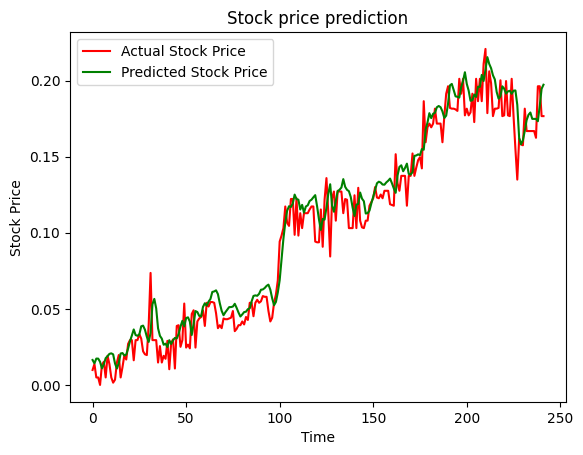

In [23]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(Y_predictions, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# The performance of the model by computing the Root Mean Squared Error(RMSE) value

In [24]:
rmse = np.sqrt(np.mean(((Y_predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.08851051091226288
